In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from sklearn.preprocessing import TargetEncoder
from stop_words import get_stop_words
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import pandas as pd

from utils.data_utils import (
    preprocessing,
    custom_train_test_split,
    generate_cm,
    plot_cm,
    plot_hist,
)

clean_df = pd.read_csv("./data/cleaned_data.csv", sep=";")

sns.set_palette("rocket")
sns.set_theme()

with pd.option_context("display.float_format", "{:.1f}".format):
    print(
        clean_df["price_pln"].describe(
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]
        )
    )

count      23752
unique      4900
top       39 900
freq         293
Name: price_pln, dtype: object


Min number of samples in bin:  138
Max number of samples in bin:  2878


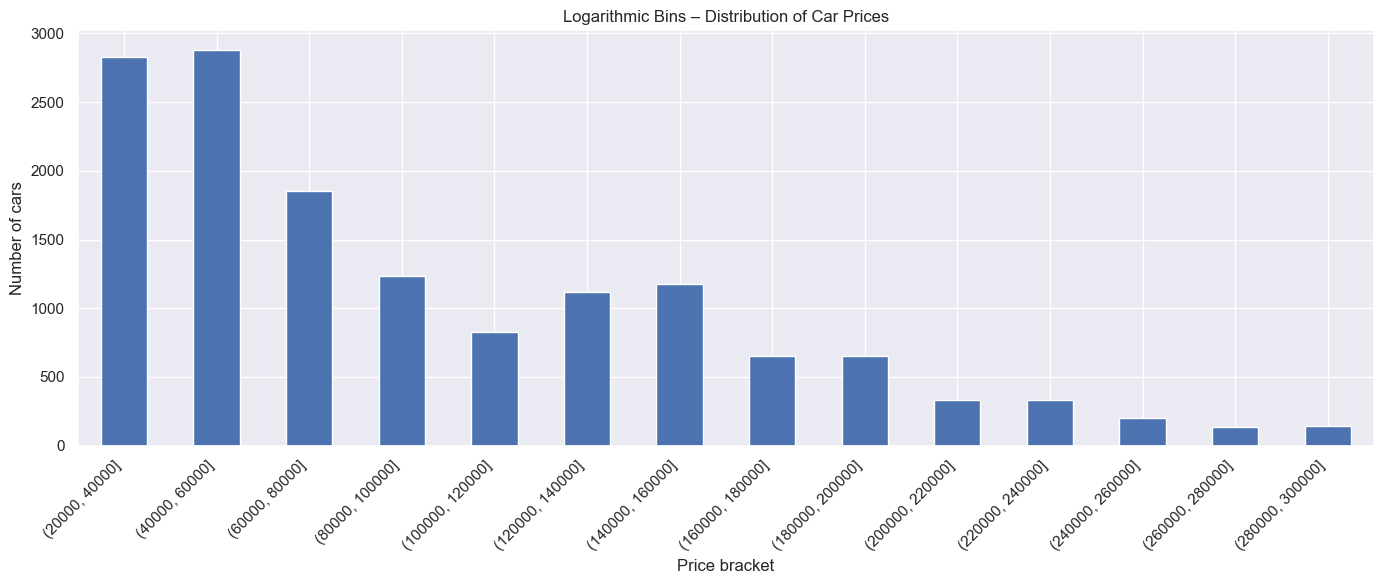

Min number of samples in bin:  376
Max number of samples in bin:  1539


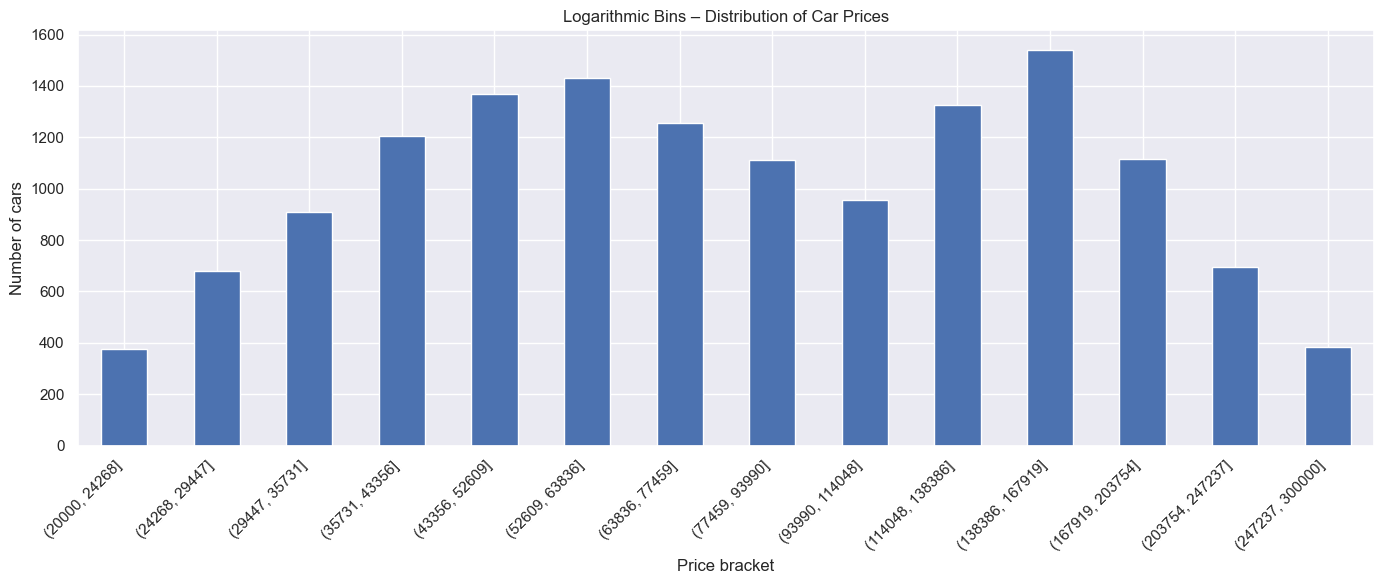

Number of classes: 14


In [63]:
df, lin_bins, log_bins = preprocessing(
    clean_df, step=20_000, min_price=20_000, max_price=300_000
)


plot_hist(
    df,
    bins=lin_bins,
    title="Linear Bins – Distribution of Car Prices",
    xlabel="Number of cars",
    ylabel="Linear Bins",
)


plot_hist(
    df,
    bins=log_bins,
    title="Logarithmic Bins – Distribution of Car Prices",
    xlabel="Number of cars",
    ylabel="Logarithmic Bins",
)


X_train, X_test, y_train, y_test = custom_train_test_split(
    df, log_bins, test_size=0.2, random_state=42, description_only=False
)


In [64]:
pl_stopwords = get_stop_words("pl")

In [ ]:
cat_feats = ["model", "condition", "fuel", "brand", "body_type", "accident_free"]
num_feats = ["year", "capacity", "power", "mileage", "seats"]

text_col = "description"

rfecv_preprocess = ColumnTransformer(
    [
        ("num", "passthrough", num_feats),
        ("cat", TargetEncoder(), cat_feats),
    ],
    remainder="drop",
)

rfecv_no_desc_model = Pipeline(
    [
        ("prep", rfecv_preprocess),
        (
            "rfecv",
            RFECV(
                estimator=RandomForestClassifier(
                    n_estimators=250, n_jobs=-1, verbose=1
                ),
                cv=3,
                step=1,
                verbose=1,
                scoring="accuracy",
                n_jobs=-1,
            ),
        ),
    ]
)


rfecv_no_desc_model.fit(X_train, y_train)

mask = rfecv_no_desc_model.named_steps["rfecv"].support_

selected_num_cols = [
    col for col, keep in zip(num_feats + cat_feats, mask) if keep and col in num_feats
]
selected_cat_cols = [
    col for col, keep in zip(num_feats + cat_feats, mask) if keep and col in cat_feats
]

print("Kept numeric:", selected_num_cols)
print("Kept categorical:", selected_cat_cols)

## TFIDF Description

In [66]:
preprocess_tfidf = ColumnTransformer(
    [
        ("text", TfidfVectorizer(max_features=5000, stop_words=pl_stopwords), text_col),
    ],
    remainder="drop",
)

rfecv_only_desc_model = Pipeline(
    [
        ("prep", preprocess_tfidf),
        ("clf", RandomForestClassifier(n_estimators=250, n_jobs=-1)),
    ]
)

rfecv_only_desc_model.fit(X_train, y_train)

/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['jeå', 'jä', 'li'] not in stop_words.
  warnings.warn(


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [94]:
def fmt_k_rounded(arr):
    return [f"{round(x/1000)}k" for x in arr]


accuracy: 0.5104384133611691

report:
               precision    recall  f1-score   support

         0.0       0.62      0.25      0.35        81
         1.0       0.50      0.38      0.43       128
         2.0       0.32      0.37      0.34       155
         3.0       0.33      0.40      0.36       252
         4.0       0.38      0.44      0.40       288
         5.0       0.42      0.51      0.46       282
         6.0       0.43      0.46      0.44       238
         7.0       0.51      0.41      0.45       234
         8.0       0.63      0.50      0.55       202
         9.0       0.68      0.60      0.63       278
        10.0       0.63      0.72      0.67       301
        11.0       0.69      0.67      0.68       224
        12.0       0.77      0.63      0.69       138
        13.0       0.64      0.63      0.63        73

    accuracy                           0.51      2874
   macro avg       0.54      0.50      0.51      2874
weighted avg       0.53      0.51      0.

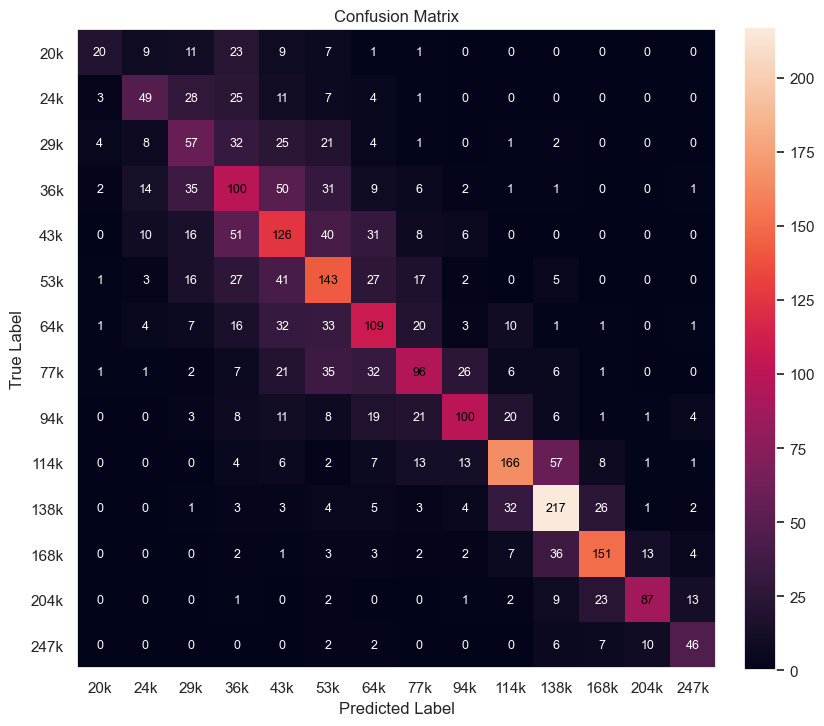

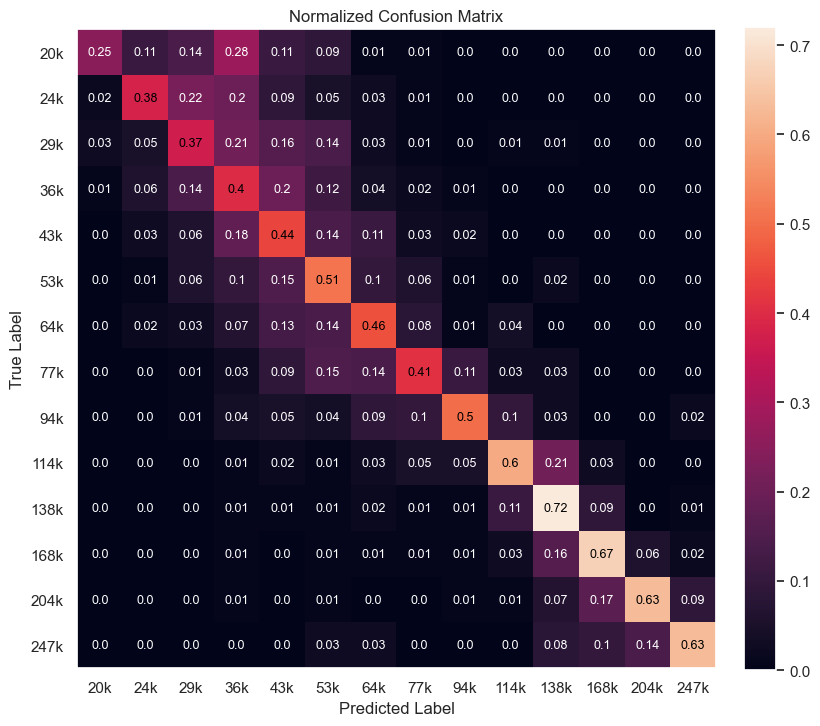

In [95]:
y_pred = rfecv_only_desc_model.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)
labels = fmt_k_rounded(log_bins)[0:-1]

plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels)


## RFECV + TFIDF Description

In [68]:
preprocess_tfidf_all_feats = ColumnTransformer(
    [
        ("num", "passthrough", selected_num_cols),
        ("cat", TargetEncoder(), selected_cat_cols),
        ("text", TfidfVectorizer(max_features=5000, stop_words=pl_stopwords), text_col),
    ],
    remainder="drop",
)

rfecv_tfidf_model = Pipeline(
    [
        ("prep", preprocess_tfidf_all_feats),
        ("clf", RandomForestClassifier(n_estimators=250, n_jobs=-1)),
    ]
)

rfecv_tfidf_model.fit(X_train, y_train)



/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['jeå', 'jä', 'li'] not in stop_words.
  warnings.warn(


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [72]:
y_test

array([ 4., 10.,  9., ...,  7.,  5.,  5.], shape=(2874,))

accuracy: 0.5379262352122477

report:
               precision    recall  f1-score   support

         0.0       0.69      0.27      0.39        81
         1.0       0.50      0.45      0.47       128
         2.0       0.45      0.45      0.45       155
         3.0       0.40      0.46      0.43       252
         4.0       0.47      0.49      0.48       288
         5.0       0.45      0.55      0.50       282
         6.0       0.39      0.50      0.44       238
         7.0       0.54      0.45      0.49       234
         8.0       0.64      0.51      0.57       202
         9.0       0.69      0.59      0.64       278
        10.0       0.63      0.73      0.68       301
        11.0       0.67      0.66      0.67       224
        12.0       0.74      0.59      0.66       138
        13.0       0.64      0.64      0.64        73

    accuracy                           0.54      2874
   macro avg       0.57      0.52      0.54      2874
weighted avg       0.55      0.54      0.

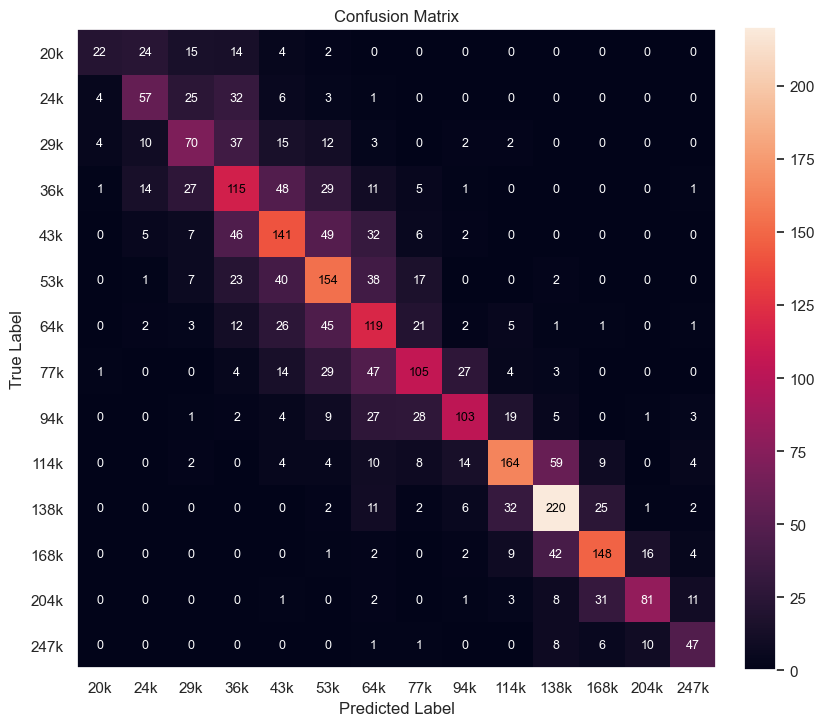

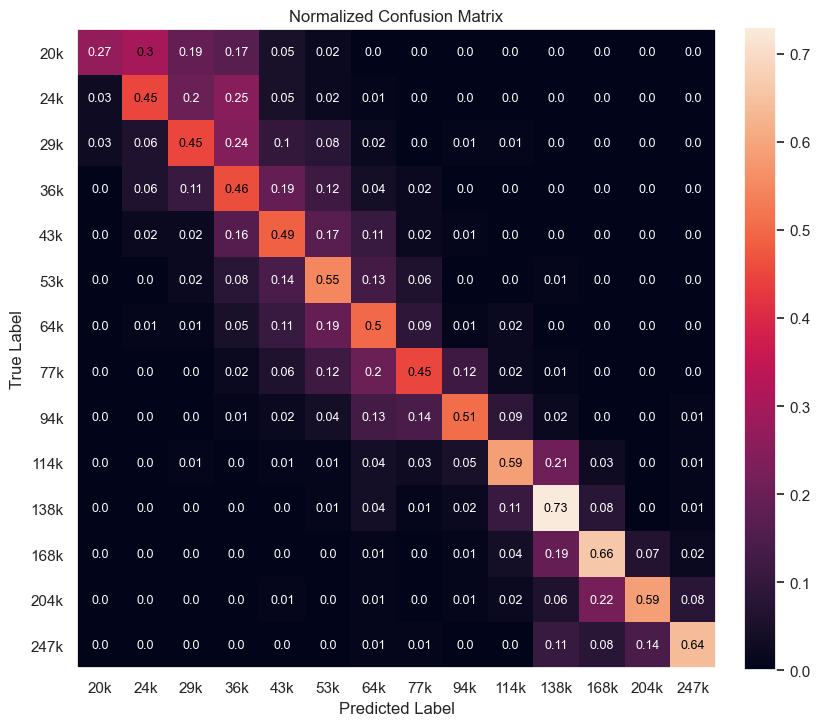

In [96]:
y_pred = rfecv_tfidf_model.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)

plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels)

## RFECV without description field

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.2s finished


accuracy: 0.5260960334029228

report:
               precision    recall  f1-score   support

         0.0       0.67      0.40      0.50        81
         1.0       0.53      0.60      0.56       128
         2.0       0.43      0.50      0.46       155
         3.0       0.46      0.44      0.45       252
         4.0       0.41      0.41      0.41       288
         5.0       0.46      0.49      0.47       282
         6.0       0.41      0.45      0.43       238
         7.0       0.52      0.51      0.51       234
         8.0       0.56      0.50      0.53       202
         9.0       0.66      0.64      0.65       278
        10.0       0.68      0.69      0.69       301
        11.0       0.57      0.57      0.57       224
        12.0       0.54      0.51      0.53       138
        13.0       0.60      0.67      0.64        73

    accuracy                           0.53      2874
   macro avg       0.54      0.53      0.53      2874
weighted avg       0.53      0.53      0.

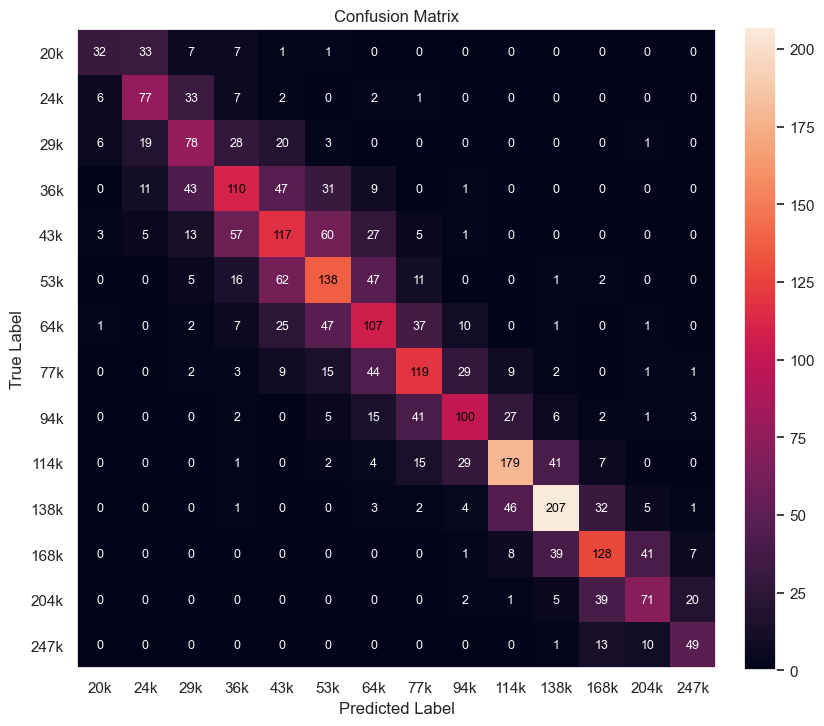

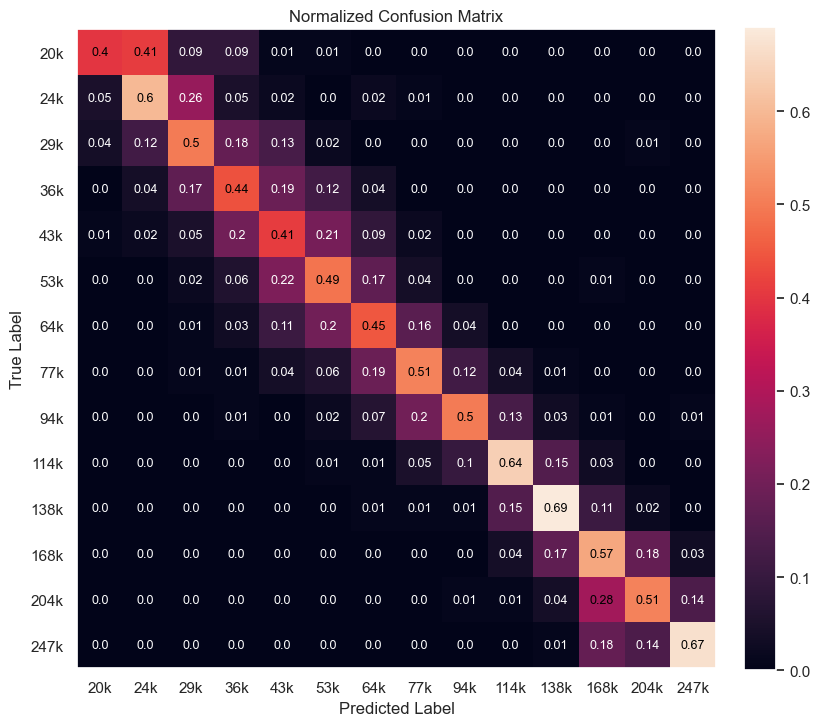

In [97]:

y_pred = rfecv_no_desc_model.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm, cm_normalized = generate_cm(y_test, y_pred)

plot_cm(cm, title="Confusion Matrix", xlabels=labels, ylabels=labels)
plot_cm(cm_normalized, title="Normalized Confusion Matrix", xlabels=labels, ylabels=labels)